In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from modules import CrackTrainDataloader, CrackTestDataloader, ResNetUNetUnfreezed, train

# Traning

### Parameters

In [2]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 3
SAVE_DIR = "./checkpoints"

### Initialize Dataloaders

In [ ]:
train_loader = CrackTrainDataloader(
    dataset_path=".data/crack_segmentation_dataset",
    batch_size=TRAIN_BATCH_SIZE
)
test_loader = CrackTestDataloader(
    dataset_path=".data/crack_segmentation_dataset",
    batch_size=TEST_BATCH_SIZE
)

### Initialize Model

In [ ]:
model = ResNetUNetUnfreezed(n_classes=1)

### Move model do GPU's

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

if device == "cuda":
    model.to(DEVICE)

### Initialize Optimizer

In [ ]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss() 

### Traning loop

In [ ]:
train(
    train_loader, test_loader, model, optimizer, criterion,
    device=DEVICE, n_epochs=NUM_EPOCHS, save_dir=SAVE_DIR
)

# Evaluation

In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from modules.transformer import CrackImageTransform

### Parameters

In [ ]:
MODEL_PATH = "./checkpoints/ResNetUNetUnfreezed_0.3908.pth"
IMAGES_PATH = "./data/crack_segmentation_dataset/test/images"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
THRESHOLD = 0.35

### Move model to GPU's

In [10]:
model = ResNetUNetUnfreezed(n_classes=1)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

if DEVICE == "cuda":
    model.to(DEVICE)
    
model.eval()
pass

### Function for segmenting image

In [14]:
def get_segment(image_path):
    transform = CrackImageTransform()
    original_img = Image.open(image_path).convert("RGB")
    input_tensor = transform(original_img).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        mask_logits, class_logits = model(input_tensor)
        probs = torch.sigmoid(mask_logits).squeeze().cpu().numpy()
        binary_mask = (probs > THRESHOLD).astype(np.float32)
        class_prob = torch.sigmoid(class_logits).item()

    return probs, binary_mask, class_prob

### Visualization function

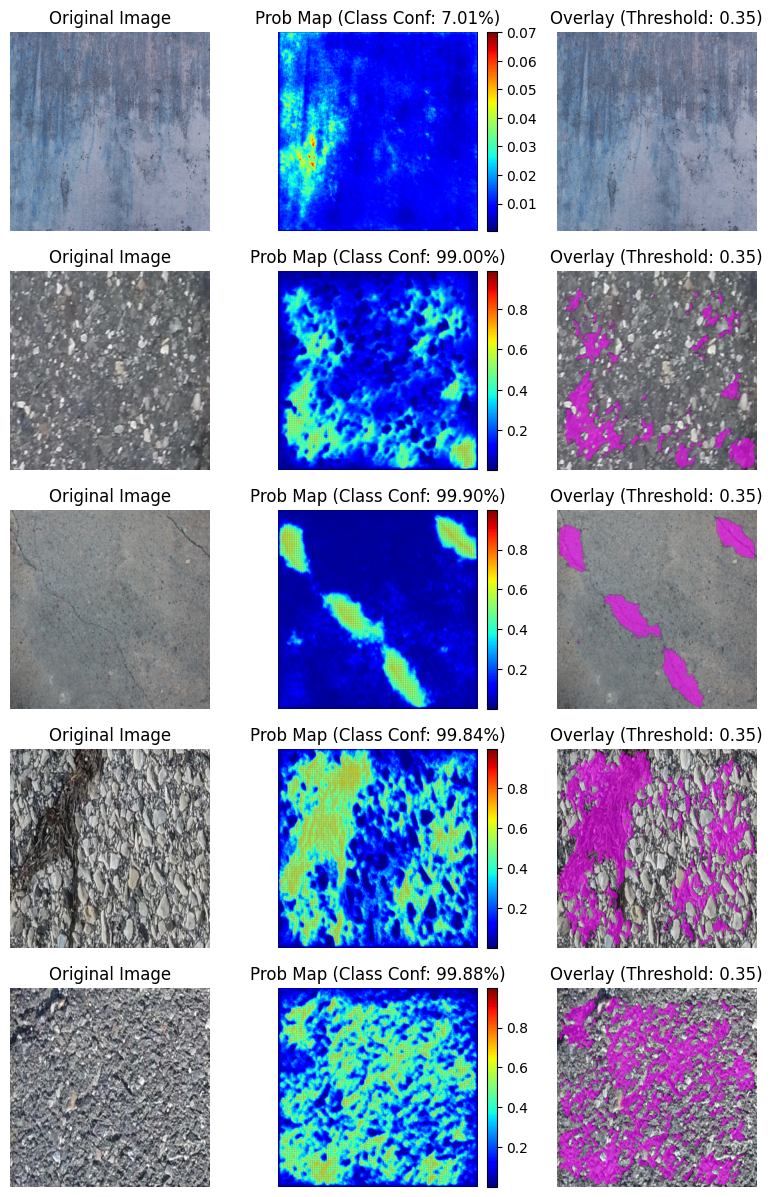

In [15]:
def viz(images_path, n=5):
    fig, ax = plt.subplots(n, 3, figsize=(10, 15))

    image_paths = [f"{images_path}/{file_name}" for file_name in os.listdir(images_path)]
    samples = np.random.choice(image_paths, size=5, replace=False)
    
    for i, file_path in enumerate(samples):
        probs, binary_mask, class_prob = get_segment(file_path)
        original_img = Image.open(file_path)
        
        # Original
        ax[i][0].imshow(original_img)
        ax[i][0].set_title("Original Image")
        ax[i][0].axis("off")
        
        # Probability Map (Heatmap)
        im1 = ax[i][1].imshow(probs, cmap='jet')
        ax[i][1].set_title(f"Prob Map (Class Conf: {class_prob:.2%})")
        ax[i][1].axis("off")
        plt.colorbar(im1, ax=ax[i][1], fraction=0.046, pad=0.04)
        
        # Binary Mask (Overlay)
        ax[i][2].imshow(original_img)
        masked = np.ma.masked_where(binary_mask == 0, binary_mask)
        ax[i][2].imshow(masked, cmap='spring', alpha=0.6)
        ax[i][2].set_title(f"Overlay (Threshold: {THRESHOLD})")
        ax[i][2].axis("off")
    
    plt.show()

viz(IMAGES_PATH)

### Generate and save submission

In [ ]:
def mask2rle(img):
   '''
   img: numpy array, 1 -> mask, 0 -> background
   Returns run length as string formated
   '''
   pixels= img.T.flatten()
   pixels = np.concatenate([[0], pixels, [0]])
   runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
   runs[1::2] -= runs[::2]
   return ' '.join(str(x) for x in runs)

In [ ]:
file_names = []
rles = []

for file_name in tqdm(os.listdir(IMAGES_PATH)):
    file_path = f"{IMAGES_PATH}/{file_name}"

    probs, binary_mask, class_prob = get_segment(file_path)
    rle = mask2rle(binary_mask)

    file_names.append(file_name)
    rles.append(rle)

df = pd.DataFrame({
    "file": file_names,
    "crack": rles
})

df.to_csv("./data/submission.csv", index=False)